In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
import tensorflow as tf
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor


import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import sklearn.linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import sklearn.impute as im
from sklearn.preprocessing import PolynomialFeatures

from datetime import timedelta
from datetime import datetime


# todo
feature importance, 
rerun nn on new data

# Data import

In [ ]:
!gdown --id 1dWfWzaISPR1Cv4tR0EtNhD1jQODV0Kp9 # train test key
!gdown --id 1ji2idP3o37gQmyR-x-n849LbhmxilxPG  # full dataset

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok]
             url_or_id
gdown: error: unrecognized arguments: df.csv


In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/hohohohia/misc/main/full_ds.csv')

In [ ]:
rdf=pd.read_csv('https://raw.githubusercontent.com/hohohohia/misc/main/reduced_ds.csv')

In [ ]:
df_full = pd.read_csv('https://raw.githubusercontent.com/hohohohia/misc/main/USDM_SMAP_SET_NOAA_full.csv')
df_full[df_full == -9999] = np.nan
FIPS = df_full.FIPS.unique()
df_full['MapDate'] = pd.to_datetime(df_full['MapDate'])
df_full['y_cat']=np.where(df_full['None'].to_numpy() ==100,0,1)

In [ ]:
def build_model( df, X_list, y_list, start_pred, pred_time, lag = 1, remove_na = True):
    # data preparation pipeline created by Yujie
    if remove_na:
        df = df.dropna()

    X_train = df[df['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag)][X_list]

    y_train = df[df['MapDate'] >= (min(df['MapDate']) + timedelta(weeks = lag))]
    y_train = y_train[y_train['MapDate'] <= start_pred][y_list]

    df_test = df[df['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) ]

    X_test = df_test[df_test['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') - timedelta(weeks = lag) + timedelta(weeks = pred_time) ][X_list]

    y_test = df_test[df_test['MapDate'] < datetime.strptime(start_pred, '%Y-%M-%d') + timedelta(weeks = pred_time)]
    y_test = y_test[y_test['MapDate'] >= datetime.strptime(start_pred, '%Y-%M-%d')][y_list]

    X_test = X_test.drop('MapDate', axis = 1)
    X_train = X_train.drop('MapDate', axis = 1)
    

    NN_model=modelmaker(X_train.shape[1])
    NN_model.fit(X_train,y_train, epochs=5, batch_size=32, validation_split = 0.2,verbose=1)
    
    eval=NN_model.evaluate(X_test,y_test)
    pred=NN_model.predict(X_test)
    NN_model=None

    return eval[1],pred,y_test



def impute(df, imp):
    return imp.fit_transform(df)


In [ ]:
df_filled = df_full.copy()
df_filled['MapDate'] = (df_full['MapDate'] - df_full['MapDate'].min())  / np.timedelta64(1,'D')


# Models
model = LogisticRegression()
imputer = im.SimpleImputer()




In [ ]:
# 1,3,4,8,16,26,52


In [ ]:
# rdf_numpy=rdf.to_numpy()

# X  =np.array(rdf_numpy[:,[4, 5,6]], dtype=np.float)
# Y0 =np.array(rdf_numpy[:,[7]], dtype=np.float)
# Y0 =np.where(Y0==100,1,0)
# X=np.hstack([X,Y0])
# Y1 =np.array(rdf_numpy[:,[8]], dtype=np.float)
# Y1 =np.where(Y1==100,1,0)
# Y2 =np.array(rdf_numpy[:,[9]], dtype=np.float)
# Y2 =np.where(Y2==100,1,0)
# Y3 =np.array(rdf_numpy[:,[10]], dtype=np.float)
# Y3 =np.where(Y3==100,1,0)
# Y4 =np.array(rdf_numpy[:,[11]], dtype=np.float)
# Y4 =np.where(Y4==100,1,0)

# def trte_split(X,Y):
#   X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=438)
#   return X_train, X_test, y_train, y_test

# X_train,_,_,_=trte_split(X,Y1)

# Neural Net Regression

## Pseudo cross sectional, mimicking OLS

In [ ]:
def modelmaker(shape):
  NN_model = Sequential()

  #input layer
  NN_model.add(Dense(128, kernel_initializer='normal',input_dim = shape, activation='relu'))

  #hidden layers
  NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dense(32, kernel_initializer='normal',activation='relu'))

  #output layer
  NN_model.add(Dense(1))

  NN_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.2))
  return NN_model

#NN_model.summary()


In [ ]:
# def model_eval(X,Y):
#   X_train, X_test, y_train, y_test = trte_split(X,Y)
#   NN_model=model()
#   NN_model.fit(X_train,y_train, epochs=5, batch_size=32, validation_split = 0.2,verbose=1)
#   eval=NN_model.evaluate(X_test,y_test)
#   pred=NN_model.predict(X_test)
#   NN_model=None
#   return eval,pred,y_test


# mse_y1,pred_y1,test_y1=model_eval(X,Y1)
# mse_y2,pred_y2,test_y2=model_eval(X,Y2)
# mse_y3,pred_y3,test_y3=model_eval(X,Y3)
# mse_y4,pred_y4,test_y4=model_eval(X,Y4)
# mses=np.round([mse_y1[1],mse_y2[1],mse_y3[1],mse_y4[1]],4)

In [ ]:
# Parameters
X_list = ['MapDate', 'roff', 'evap','smap','PRCP']
y_list = ['y_cat']
start_pred = '2021-01-01'
pred_time = 4

vars = X_list.copy()
[vars.append(y) for y in y_list]


df_filled = impute(df_filled[vars], imputer)

df_filled = pd.DataFrame(df_filled, columns = vars)

df_filled = df_filled.rename(columns = {'MapDate' : 'week'})
df_filled['MapDate'] = df_full['MapDate']

X_list.append('week')
df_filled

,week,roff,evap,smap,PRCP,y_cat,MapDate
0,0.0,0.000421,-0.000291,0.244380,0.000000,1.0,2011-12-27
1,7.0,0.000421,-0.000291,0.244380,48.714286,1.0,2012-01-03
2,14.0,0.000421,-0.000291,0.244380,33.714286,1.0,2012-01-10
3,21.0,0.000421,-0.000291,0.244380,102.285714,1.0,2012-01-17
4,28.0,0.000421,-0.000291,0.244380,199.571429,0.0,2012-01-24
...,...,...,...,...,...,...,...
238945,3682.0,0.000421,-0.000291,0.191903,0.000000,1.0,2022-01-25
238946,3689.0,0.000421,-0.000291,0.191361,0.428571,1.0,2022-02-01
238947,3696.0,0.000421,-0.000291,0.190819,0.000000,1.0,2022-02-08
238948,3703.0,0.000421,-0.000291,0.190668,3.000000,1.0,2022-02-15


In [ ]:
Xs = ['MapDate','roff', 'evap','smap','PRCP','y_cat']

In [ ]:
weeks = [1,3,4,8,16,26,52]
lags = [1, 2, 3, 4, 5]

results = pd.DataFrame(index = lags, columns = weeks)


df_test = df_filled

for week in weeks:
    for lag in lags:
        res = build_model( df_test, Xs, y_list[0], start_pred, week, lag = lag)
        results.loc[lag, week] = res[0]

Epoch 1/5
5288/5288 [==============================] - 31s 6ms/step - loss: 0.1788 - binary_accuracy: 0.9514 - val_loss: 0.1672 - val_binary_accuracy: 0.9561
Epoch 2/5
5288/5288 [==============================] - 30s 6ms/step - loss: 0.1661 - binary_accuracy: 0.9572 - val_loss: 0.1661 - val_binary_accuracy: 0.9558
Epoch 3/5
5288/5288 [==============================] - 30s 6ms/step - loss: 0.1630 - binary_accuracy: 0.9576 - val_loss: 0.1689 - val_binary_accuracy: 0.9547
Epoch 4/5
5288/5288 [==============================] - 29s 6ms/step - loss: 0.1630 - binary_accuracy: 0.9575 - val_loss: 0.1656 - val_binary_accuracy: 0.9562
Epoch 5/5
15/15 [==============================] - 0s 2ms/step - loss: 0.1626 - binary_accuracy: 0.9556
Epoch 1/5
5277/5277 [==============================] - 30s 6ms/step - loss: 0.2748 - binary_accuracy: 0.9155 - val_loss: 0.2901 - val_binary_accuracy: 0.9118
Epoch 2/5
5277/5277 [==============================] - 29s 6ms/step - loss: 0.2642 - binary_accuracy: 0.92

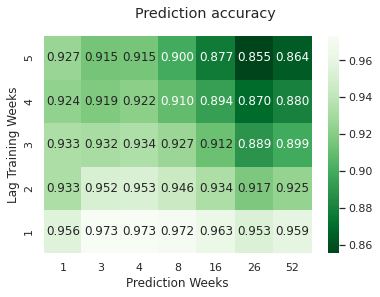

In [ ]:
results = results.astype(float)
ax  = sns.heatmap(results, annot = True, cmap = 'Greens_r', fmt='.3f')
ax.set_xlabel('Prediction Weeks')
ax.set_ylabel('Lag Training Weeks')
ax.invert_yaxis()
plt.suptitle('Prediction accuracy')
plt.show()

In [ ]:
# %%capture
# !pip install prettytable

In [ ]:
# from prettytable import PrettyTable
# x = PrettyTable()
# x.add_column("For n weeks into the future",
# ["1  week","2 weeks","3 weeks","4 weeks"])
# x.add_column("Accuracy", mses)

# print(x)

In [ ]:
# def binarize(x):
#   return np.where(x>0.2,1,0)

In [ ]:
# def util1(pred_y1):

#   all_P=np.sum(binarize(pred_y1))
#   all_N=pred_y1.shape[0]-all_P

#   dot=np.array([[1/all_N,1/all_P],
#               [1/all_N,1/all_P]])
#   return dot

In [ ]:
#np.multiply(confusion_matrix(binarize(pred_y1),test_y1),util1(pred_y1))


#true negative, false positive
#false negative, true positive

In [ ]:
#np.multiply(confusion_matrix(binarize(pred_y2),test_y2),util1(pred_y2))

In [ ]:
#np.multiply(confusion_matrix(binarize(pred_y3),test_y3),util1(pred_y3))

In [ ]:
#np.multiply(confusion_matrix(binarize(pred_y4),test_y4),util1(pred_y4))